In [2]:


import torch 
import torch.nn as nn 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train = pd.read_csv('D:\Sign Language Recognization\sign_mnist_train.csv')
test = pd.read_csv('D:\Sign Language Recognization\sign_mnist_test.csv')
     

In [6]:

train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:

X = train.drop(['label'], axis = 1)
y = train['label']

In [10]:
X.shape,y.shape

((27455, 784), (27455,))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [12]:

BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

In [13]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize the image to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the overall transformation pipeline
transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  # Apply random transformations with a probability of 0.5
    fixed_transforms
])
     

In [14]:

class SignDataSet(Dataset):
  def __init__(
      self,
      image_df, 
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df 
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split 
    self.transform = transform

  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]
    # label = torch.nn.functional.one_hot(torch.tensor(label))

    if self.split == 'train':
      image = self.transform(image)
    return image, label
    
  
  

In [15]:
train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [16]:

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

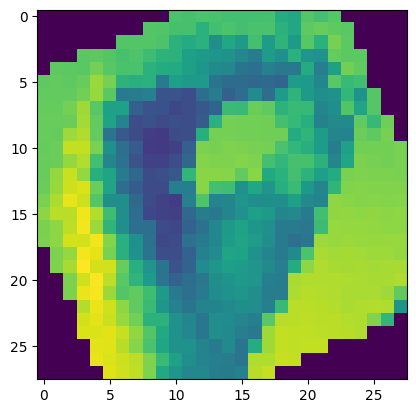

In [17]:
for i, j in train_data: 
  temp_img = i 

  plt.imshow(temp_img.permute(1,2,0))
  break

Model Building

In [18]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
  # Number of classes
model = SignLabelModel(NUM_CLASS).to(device)

In [19]:

num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [20]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 3.1703
Epoch [1/20], Loss: 2.7078
Epoch [1/20], Loss: 2.0456
Epoch [1/20], Loss: 2.1593
Epoch [1/20], Loss: 1.9074
Epoch [1/20], Loss: 1.9114


  5%|▌         | 1/20 [00:16<05:10, 16.32s/it]

Epoch [2/20], Loss: 1.5141
Epoch [2/20], Loss: 1.5089
Epoch [2/20], Loss: 1.0297
Epoch [2/20], Loss: 1.2930
Epoch [2/20], Loss: 1.2208
Epoch [2/20], Loss: 1.1198


 10%|█         | 2/20 [00:37<05:40, 18.93s/it]

Epoch [3/20], Loss: 1.2490
Epoch [3/20], Loss: 1.1231
Epoch [3/20], Loss: 0.7540
Epoch [3/20], Loss: 0.9770
Epoch [3/20], Loss: 0.7343
Epoch [3/20], Loss: 0.9612


 15%|█▌        | 3/20 [00:55<05:14, 18.52s/it]

Epoch [4/20], Loss: 0.7621
Epoch [4/20], Loss: 0.8829
Epoch [4/20], Loss: 0.5904
Epoch [4/20], Loss: 0.8611
Epoch [4/20], Loss: 0.5063
Epoch [4/20], Loss: 0.6960


 20%|██        | 4/20 [01:18<05:26, 20.38s/it]

Epoch [5/20], Loss: 0.7334
Epoch [5/20], Loss: 0.7252
Epoch [5/20], Loss: 0.3137
Epoch [5/20], Loss: 0.5409
Epoch [5/20], Loss: 0.4329
Epoch [5/20], Loss: 0.7059


 25%|██▌       | 5/20 [01:40<05:15, 21.05s/it]

Epoch [6/20], Loss: 0.4873
Epoch [6/20], Loss: 0.4711
Epoch [6/20], Loss: 0.3302
Epoch [6/20], Loss: 0.4418
Epoch [6/20], Loss: 0.5818
Epoch [6/20], Loss: 0.3180


 30%|███       | 6/20 [02:00<04:49, 20.70s/it]

Epoch [7/20], Loss: 0.6849
Epoch [7/20], Loss: 0.5364
Epoch [7/20], Loss: 0.4415
Epoch [7/20], Loss: 0.3392
Epoch [7/20], Loss: 0.4145
Epoch [7/20], Loss: 0.3337


 35%|███▌      | 7/20 [02:20<04:24, 20.35s/it]

Epoch [8/20], Loss: 0.2728
Epoch [8/20], Loss: 0.5173
Epoch [8/20], Loss: 0.2376
Epoch [8/20], Loss: 0.3908
Epoch [8/20], Loss: 0.2140
Epoch [8/20], Loss: 0.3914


 40%|████      | 8/20 [02:39<04:00, 20.06s/it]

Epoch [9/20], Loss: 0.2278
Epoch [9/20], Loss: 0.3921
Epoch [9/20], Loss: 0.1777
Epoch [9/20], Loss: 0.2330
Epoch [9/20], Loss: 0.3447
Epoch [9/20], Loss: 0.2567


 45%|████▌     | 9/20 [03:00<03:44, 20.38s/it]

Epoch [10/20], Loss: 0.6613
Epoch [10/20], Loss: 0.3416
Epoch [10/20], Loss: 0.1226
Epoch [10/20], Loss: 0.2072
Epoch [10/20], Loss: 0.1437
Epoch [10/20], Loss: 0.2774


 50%|█████     | 10/20 [03:21<03:26, 20.61s/it]

Epoch [11/20], Loss: 0.3695
Epoch [11/20], Loss: 0.2576
Epoch [11/20], Loss: 0.1456
Epoch [11/20], Loss: 0.2363
Epoch [11/20], Loss: 0.1213
Epoch [11/20], Loss: 0.0686


 55%|█████▌    | 11/20 [03:43<03:09, 21.06s/it]

Epoch [12/20], Loss: 0.3786
Epoch [12/20], Loss: 0.2721
Epoch [12/20], Loss: 0.0610
Epoch [12/20], Loss: 0.0872
Epoch [12/20], Loss: 0.0952
Epoch [12/20], Loss: 0.1764


 60%|██████    | 12/20 [04:05<02:50, 21.33s/it]

Epoch [13/20], Loss: 0.2326
Epoch [13/20], Loss: 0.1454
Epoch [13/20], Loss: 0.1346
Epoch [13/20], Loss: 0.1014
Epoch [13/20], Loss: 0.1550
Epoch [13/20], Loss: 0.1755


 65%|██████▌   | 13/20 [04:28<02:31, 21.58s/it]

Epoch [14/20], Loss: 0.2586
Epoch [14/20], Loss: 0.2596
Epoch [14/20], Loss: 0.0661
Epoch [14/20], Loss: 0.1164
Epoch [14/20], Loss: 0.1944
Epoch [14/20], Loss: 0.0684


 70%|███████   | 14/20 [04:47<02:04, 20.81s/it]

Epoch [15/20], Loss: 0.1958
Epoch [15/20], Loss: 0.0973
Epoch [15/20], Loss: 0.0836
Epoch [15/20], Loss: 0.0964
Epoch [15/20], Loss: 0.0632
Epoch [15/20], Loss: 0.1227


 75%|███████▌  | 15/20 [05:07<01:43, 20.60s/it]

Epoch [16/20], Loss: 0.1397
Epoch [16/20], Loss: 0.1168
Epoch [16/20], Loss: 0.0861
Epoch [16/20], Loss: 0.1233
Epoch [16/20], Loss: 0.0627
Epoch [16/20], Loss: 0.1054


 80%|████████  | 16/20 [05:27<01:22, 20.51s/it]

Epoch [17/20], Loss: 0.1236
Epoch [17/20], Loss: 0.1212
Epoch [17/20], Loss: 0.0374
Epoch [17/20], Loss: 0.0471
Epoch [17/20], Loss: 0.0597
Epoch [17/20], Loss: 0.0370


 85%|████████▌ | 17/20 [05:48<01:02, 20.75s/it]

Epoch [18/20], Loss: 0.1274
Epoch [18/20], Loss: 0.0497
Epoch [18/20], Loss: 0.0632
Epoch [18/20], Loss: 0.0492
Epoch [18/20], Loss: 0.0158
Epoch [18/20], Loss: 0.0432


 90%|█████████ | 18/20 [06:10<00:41, 20.99s/it]

Epoch [19/20], Loss: 0.1311
Epoch [19/20], Loss: 0.1305
Epoch [19/20], Loss: 0.0462
Epoch [19/20], Loss: 0.0367
Epoch [19/20], Loss: 0.1177
Epoch [19/20], Loss: 0.0426


 95%|█████████▌| 19/20 [06:33<00:21, 21.63s/it]

Epoch [20/20], Loss: 0.0426
Epoch [20/20], Loss: 0.0758
Epoch [20/20], Loss: 0.0706
Epoch [20/20], Loss: 0.0638
Epoch [20/20], Loss: 0.2270
Epoch [20/20], Loss: 0.0802


100%|██████████| 20/20 [06:54<00:00, 20.74s/it]

Training finished.
